In [34]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [35]:
#tenors
t = np.array([0.083,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30,40,50])

#market rates
y=np.array([0.018061,0.018766,0.021550,0.023801,0.024502,0.027370,0.028345,0.029934,0.031454,0.031421,0.0359,0.037271,0.037777,0.03768,0.03778])

curve_fit, status = calibrate_nss_ols(t,y) #NSS model calibrate

NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t)

In [36]:
cash_flow_table = pd.read_excel('Cash_flow_table.xlsx')
cash_flow_table #day_adj 向前移动现金流

,start,end,growth_rate,gr_frequency,cashflow,approach,frequency,interest_up,discount,day_adj
0,2022-03-16,2045-05-06,0.03,Y,400,regular,M,0.00,curve,0
1,2021-07-13,2033-05-06,0.02,M,900,regular,M,0.02,0.02,0
2,2021-08-06,2062-05-16,0.03,2M,500,regular,2M,0.05,0.05,0
3,2022-01-12,2055-02-05,0.03,Y,-200,regular,3M,0.03,curve,5
4,2022-01-12,2022-01-12,0.00,0,1000,one_time,D,0.03,curve,0


In [37]:
def cf(cash_flow_table):

    df5 = pd.DataFrame({'A' : []})# 增长后现金流表

    for i in range(len(cash_flow_table)):
        if cash_flow_table.at[i, 'approach']=='regular':
                
            df_index = pd.date_range(start=cash_flow_table.at[i, 'start'], 
            end=cash_flow_table.at[i, 'end'],
            freq=cash_flow_table.at[i, 'frequency']) # 生成时间索引

            df1=pd.DataFrame(index = df_index)
            df1['cashflow'] = cash_flow_table.at[i, 'cashflow'] # 添加无增长现金流


            df_index1 = pd.date_range(start=cash_flow_table.at[i, 'start'], 
            end=cash_flow_table.at[i, 'end'],
            freq=cash_flow_table.at[i, 'gr_frequency'])
            
            growth_sequence = np.logspace(start=0,stop=len(df_index1)-1, 
            base=cash_flow_table.at[i, 'growth_rate']+1, num = len(df_index1)) # 生成更低频率的等比数列

            df2 = pd.DataFrame(growth_sequence,index = df_index1)
            df2=df2.resample(cash_flow_table.at[i, 'frequency'], convention='end').asfreq()#.fillna(method='bfill') # 展开成高频数据
            df2.columns = ['Growth_factor']
            
            df3=pd.concat([df1,df2],axis=1)
            df3['Growth_factor']=df3['Growth_factor'].fillna(method='bfill')
            df3['Growth_factor']=df3['Growth_factor'].fillna(growth_sequence[-1]*(cash_flow_table.at[i, 'growth_rate']+1))
            df3 = df3.fillna(0)

            df3["Growth_cash_flow_"+str(i)]=df3['cashflow']*df3['Growth_factor'] # 增长后现金流

            df4 = df3.drop(['cashflow','Growth_factor'],axis=1)
            

        elif cash_flow_table.at[i, 'approach']=='one_time':
            
            df_index = pd.date_range(start=cash_flow_table.at[i, 'start'], 
            end=cash_flow_table.at[i, 'end'],
            freq=cash_flow_table.at[i, 'frequency'])

            df1=pd.DataFrame(index = df_index)
            df1["Growth_cash_flow_"+str(i)] = cash_flow_table.at[i, 'cashflow']
            df4=df1
            
        
        df5=pd.concat([df5, df4],axis=1)
    
    df5=df5.drop(['A'],axis=1).fillna(0)
    
    return df5

In [38]:
no_discount_cashflow=cf(cash_flow_table)
no_discount_cashflow

,Growth_cash_flow_0,Growth_cash_flow_1,Growth_cash_flow_2,Growth_cash_flow_3,Growth_cash_flow_4
2021-07-31,0.0,900.000000,0.000000,0.0,0.0
2021-08-31,0.0,918.000000,500.000000,0.0,0.0
2021-09-30,0.0,936.360000,0.000000,0.0,0.0
2021-10-31,0.0,955.087200,515.000000,0.0,0.0
2021-11-30,0.0,974.188944,0.000000,0.0,0.0
...,...,...,...,...,...
2061-08-31,0.0,0.000000,602426.313964,0.0,0.0
2061-10-31,0.0,0.000000,620499.103383,0.0,0.0
2061-12-31,0.0,0.000000,639114.076484,0.0,0.0
2062-02-28,0.0,0.000000,658287.498779,0.0,0.0


In [39]:
def discount(no_discount_cashflow,cash_flow_table):
    df2 = pd.DataFrame({'A' : []})
    for i in range(len(cash_flow_table)):
        if cash_flow_table.at[i, 'discount']=='curve':

            df=no_discount_cashflow[['Growth_cash_flow_'+str(i)]]

            interval=((pd.to_datetime(df.index)-datetime.datetime.now()).days+cash_flow_table.at[i, 'day_adj'])/365 # 计算现金流表距今时间
            interest_rate = NelsonSiegelSvenssonCurve.zero(curve_fit,interval) + cash_flow_table.at[i,'interest_up'] # 拟合利率曲线

            discount_factor = (np.array(interest_rate)+1+cash_flow_table.at[i, 'interest_up'])**np.array(-interval)
            discount_factor = discount_factor.reshape((len(discount_factor),1))

            df1 = df*discount_factor
            df1.columns = ["discounted_cash_flow_"+str(i)]

        else:
            df=no_discount_cashflow[['Growth_cash_flow_'+str(i)]]

            interval=(pd.to_datetime(df.index)-datetime.datetime.now()).days/365 # 计算现金流表距今时间
            interest_rate = np.array([cash_flow_table.at[i, 'discount']]*len(interval)) # 生成常数利率

            discount_factor = (np.array(interest_rate)+1+cash_flow_table.at[i, 'interest_up'])**np.array(-interval)
            discount_factor = discount_factor.reshape((len(discount_factor),1))

            df1 = df*discount_factor
            df1.columns = ["discounted_cash_flow_"+str(i)]

        df2=pd.concat([df2, df1],axis=1)
    
    df2=df2.drop(['A'],axis=1)
    return df2

In [40]:
discounted_cashflow=discount(no_discount_cashflow,cash_flow_table)
discounted_cashflow

,discounted_cash_flow_0,discounted_cash_flow_1,discounted_cash_flow_2,discounted_cash_flow_3,discounted_cash_flow_4
2021-07-31,0.0,913.347081,0.000000,0.0,0.0
2021-08-31,0.0,928.515910,514.032873,0.0,0.0
2021-09-30,0.0,944.038097,0.000000,0.0,0.0
2021-10-31,0.0,959.716641,521.087238,0.0,0.0
2021-11-30,0.0,975.760418,0.000000,0.0,0.0
...,...,...,...,...,...
2061-08-31,0.0,0.000000,13648.451175,0.0,0.0
2061-10-31,0.0,0.000000,13835.756609,0.0,0.0
2061-12-31,0.0,0.000000,14025.632542,0.0,0.0
2062-02-28,0.0,0.000000,14225.541565,0.0,0.0


In [41]:
discounted_column_total=pd.DataFrame(discounted_cashflow.sum(axis=1))
discounted_column_total.columns = ['discounted_total_cashflow']
discounted_column_total

,discounted_total_cashflow
2021-07-31,913.347081
2021-08-31,1442.548783
2021-09-30,944.038097
2021-10-31,1480.803879
2021-11-30,975.760418
...,...
2061-08-31,13648.451175
2061-10-31,13835.756609
2061-12-31,14025.632542
2062-02-28,14225.541565


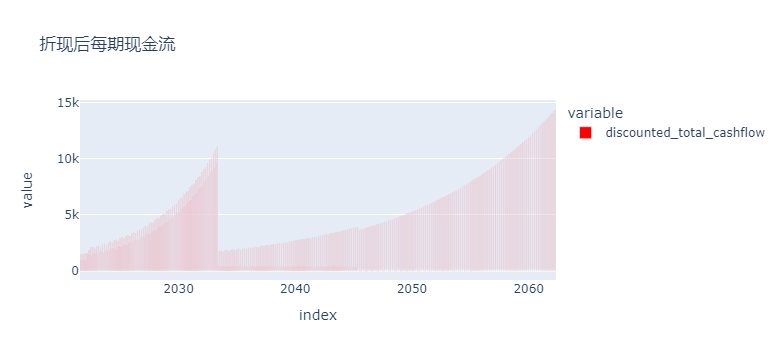

In [43]:
import plotly.express as px

fig = px.bar(discounted_column_total,title="折现后每期现金流")
fig.update_traces(marker_color='red')
fig.show()

In [44]:
def duration_convexity(discounted_column_total,curve_fit):
    interval=np.array((pd.to_datetime(discounted_column_total.index)-datetime.datetime.now()).days)/365
    interest_rate = np.array(NelsonSiegelSvenssonCurve.zero(curve_fit,interval))
    discount_factor = (interest_rate+1)**np.array(-interval)

    weight=np.array(discounted_column_total['discounted_total_cashflow'])/np.sum(discounted_column_total['discounted_total_cashflow'])
    
    Mc_duration=np.sum(weight*interval)

    Mc_convexity=np.sum(weight*interval*(interval+1)*discount_factor)
    
    return np.array([Mc_duration,Mc_convexity])

duration_convexity(discounted_column_total,curve_fit)

array([ 21.71210802, 206.50121113])